
<h1 align="center">Feature Engineering et Stratégie</h1>


In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

Dans ce notebook, on explore comment améliorer mon classifieur grâce à un feature engineering avancé.  Vérifier une hypothèse : si on traite le Titre et la Description séparément (en pondérant davantage le titre), est-ce que j'obtiens de meilleurs résultats qu'en les fusionnant ?

In [2]:
df = pd.read_csv("rakuten_text_train_v1.csv")
df.head()

,productid,imageid,prdtypecode,designation_cleaned,description_cleaned,text_cleaned,dup_count,is_duplicated_group
0,3804725264,1263597046,10,olivia: personalisiertes notizbuch 150 seiten ...,NaN,olivia: personalisiertes notizbuch 150 seiten ...,1,False
1,436067568,1008141237,2280,journal arts (le) n° 133 28/09/2001 l'art marc...,NaN,journal arts (le) n° 133 28/09/2001 l'art marc...,1,False
2,201115110,938777978,50,grand stylet ergonomique bleu gamepad nintendo...,pilot style touch pen marque speedlink stylet ...,grand stylet ergonomique bleu gamepad nintendo...,1,False
3,50418756,457047496,1280,peluche donald europe disneyland 2000 (marionn...,NaN,peluche donald europe disneyland 2000 (marionn...,1,False
4,278535884,1077757786,2705,guerre tuques,luc idées grandeur veut organiser jeu guerre b...,guerre tuques luc idées grandeur veut organise...,1,False



<h2> 1. Fonctions utilitaires pour les features </h2>


- Je définis une fonction de sécurité pour les chaînes de caractères. Je fais ici une préparation cruciale pour ma comparaison :  Je crée une colonne text_all qui regroupe titre et description. Cela me servira de baseline pour voir si mon approche "séparée" apporte vraiment quelque chose.

In [3]:
# Toutes les colonnes texte utilisées par TF-IDF doivent être des chaînes non nulles
text_cols_base = ["designation_cleaned", "description_cleaned", "text_cleaned"]
for col in text_cols_base:
    if col in df.columns:
        df[col] = df[col].fillna("").astype(str)

# S'assurer que les colonnes de duplication sont numériques
for col in ["dup_count", "is_duplicated_group"]:
    if col in df.columns:
        # remplacement des NaN par 0
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)


def safe_str(s):
    """Convertit une valeur en chaîne de caractères sans NaN."""
    if isinstance(s, str):
        return s
    if pd.isna(s):
        return ""
    return str(s)

- <h3> Statistiques de base sur le texte </h3>

<p>Je calcule d'abord la longueur (nombre de caractères et de mots), puis **j'**utilise des expressions régulières pour compter des éléments spécifiques aux produits e-commerce : la présence de chiffres, d'unités de mesure (comme 'kg', 'ml', 'cm') et de motifs de dimensions (type '10x20'). Cela me permet de transformer du texte brut en indicateurs numériques concrets pour mon modèle.</p>

In [4]:
def basic_text_stats(s: str) -> dict:
    """Calcule des statistiques simples sur une chaîne de caractères."""
    s = safe_str(s)
    s_strip = s.strip()
    
    length_char = len(s_strip)
    tokens = s_strip.split()
    length_tokens = len(tokens)

    num_digits = sum(ch.isdigit() for ch in s_strip)
    num_upper = sum(ch.isupper() for ch in s_strip)
    num_punct = sum(ch in ".,;:!?/\\-+()" for ch in s_strip)

    ratio_digits = num_digits / length_char if length_char > 0 else 0.0
    ratio_upper = num_upper / length_char if length_char > 0 else 0.0

    size_pattern = re.compile(r"\b\d+\s*(cm|mm|ml|l|kg|g)\b", flags=re.IGNORECASE)
    num_size = len(size_pattern.findall(s_strip))

    return {
        "len_char": length_char,
        "len_tokens": length_tokens,
        "ratio_digits": ratio_digits,
        "ratio_upper": ratio_upper,
        "num_punct": num_punct,
        "num_size_patterns": num_size,
    }

- Features "pragmatiques" sur le texte

Je définis manuellement des motifs de ponctuation (points d'exclamation, d'interrogation, signes 'plus', slashs) et des listes de mots-clés décrivant des matériaux (bois, métal...) et des couleurs. Ensuite, ma fonction meta_features_from_text parcourt le texte pour compter précisément l'occurrence de ces éléments. Mon intuition est que la présence de ces indices spécifiques (comme la mention d'une couleur ou une ponctuation expressive) peut aider le modèle à mieux distinguer certaines catégories de produits.

In [5]:
EXCLAMATION_RE = re.compile(r"!")
QUESTION_RE = re.compile(r"\?")
PLUS_RE = re.compile(r"\+")
SLASH_RE = re.compile(r"/")

# Petites listes de mots pour le matériau et la couleur
MATERIAL_WORDS = {"bois", "metal", "métal", "acier", "coton", "plastique", "cuir"}
COLOR_WORDS = {"rouge", "bleu", "noir", "blanc", "rose", "gris", "vert", "jaune"}

def meta_features_from_text(s: str) -> dict:
    """Extrait des features "pragmatiques" d'un texte nettoyé."""
    s = safe_str(s)
    s_lower = s.lower()
    tokens = s_lower.split()
    
    return {
        "num_exclamation": len(EXCLAMATION_RE.findall(s)),
        "num_question": len(QUESTION_RE.findall(s)),
        "num_plus": len(PLUS_RE.findall(s)),
        "num_slash": len(SLASH_RE.findall(s)),
        "num_material_words": sum(word in MATERIAL_WORDS for word in tokens),
        "num_color_words": sum(word in COLOR_WORDS for word in tokens),
    }

# ---------- 2.3 Features "produit" simples ----------

In [6]:
def product_level_features(df: pd.DataFrame) -> pd.DataFrame:
    """Crée des features simples au niveau produit (description présente, longueur, etc.)."""
    # Ici, on n'a plus la colonne 'description' brute, donc on
    # utilise 'description_cleaned' comme approximation.
    df["has_description"] = df["description_cleaned"].fillna("").apply(
        lambda s: int(len(safe_str(s).strip()) > 0)
    )

    df["desc_len_tokens_raw"] = df["description_cleaned"].fillna("").apply(
        lambda s: len(safe_str(s).split())
    )

    # Seuil arbitraire, à ajuster après EDA si besoin
    df["desc_is_long"] = (df["desc_len_tokens_raw"] > 50).astype(int)

    df["title_has_digit"] = df["designation_cleaned"].fillna("").apply(
        lambda s: int(any(ch.isdigit() for ch in safe_str(s)))
    )

    return df

# ============================================
# 3. Application des features de structure
# ============================================

In [7]:
# --- 3.1 Statistiques de base sur titre et description ---
for col in ["designation_cleaned", "description_cleaned"]:
    stats_series = df[col].apply(basic_text_stats)
    stats_df = pd.DataFrame(list(stats_series))
    for stat_col in stats_df.columns:
        new_col_name = f"{col}_{stat_col}"
        df[new_col_name] = stats_df[stat_col]

# --- 3.2 Features pragmatiques sur text_cleaned ---
meta_series = df["text_cleaned"].apply(meta_features_from_text)
meta_df = pd.DataFrame(list(meta_series))
for c in meta_df.columns:
    df[c] = meta_df[c]

# --- 3.3 Features produit ---
df = product_level_features(df)

print("Colonnes après ajout des features :")
print(df.columns)

Colonnes après ajout des features :
Index(['productid', 'imageid', 'prdtypecode', 'designation_cleaned',
       'description_cleaned', 'text_cleaned', 'dup_count',
       'is_duplicated_group', 'designation_cleaned_len_char',
       'designation_cleaned_len_tokens', 'designation_cleaned_ratio_digits',
       'designation_cleaned_ratio_upper', 'designation_cleaned_num_punct',
       'designation_cleaned_num_size_patterns', 'description_cleaned_len_char',
       'description_cleaned_len_tokens', 'description_cleaned_ratio_digits',
       'description_cleaned_ratio_upper', 'description_cleaned_num_punct',
       'description_cleaned_num_size_patterns', 'num_exclamation',
       'num_question', 'num_plus', 'num_slash', 'num_material_words',
       'num_color_words', 'has_description', 'desc_len_tokens_raw',
       'desc_is_long', 'title_has_digit'],
      dtype='object')


# ============================================
# 4. Préparation des listes de features
# ============================================

In [8]:
# Colonnes textuelles pour TF-IDF (titre et description séparés)
text_cols = ["designation_cleaned", "description_cleaned"]

# Colonnes numériques (meta + stats) à inclure dans le modèle
meta_cols = [
    # Features produit
    "has_description",
    "desc_len_tokens_raw",
    "desc_is_long",
    "title_has_digit",
    
    # Statistiques de base sur le titre
    "designation_cleaned_len_char",
    "designation_cleaned_len_tokens",
    "designation_cleaned_ratio_digits",
    "designation_cleaned_ratio_upper",
    "designation_cleaned_num_punct",
    "designation_cleaned_num_size_patterns",
    
    # Statistiques de base sur la description
    "description_cleaned_len_char",
    "description_cleaned_len_tokens",
    "description_cleaned_ratio_digits",
    "description_cleaned_ratio_upper",
    "description_cleaned_num_punct",
    "description_cleaned_num_size_patterns",
    
    # Features pragmatiques
    "num_exclamation",
    "num_question",
    "num_plus",
    "num_slash",
    "num_material_words",
    "num_color_words",
    
    # Features de duplication (issues du notebook 1)
    "dup_count",
    "is_duplicated_group",
]

# On s'assure que toutes les colonnes existent
meta_cols = [c for c in meta_cols if c in df.columns]

print("Nombre de colonnes numériques sélectionnées :", len(meta_cols))

# Variable cible
y = df["prdtypecode"].values

# DataFrame de travail pour le ColumnTransformer
X = df[text_cols + meta_cols]

print("Forme de X :", X.shape)

Nombre de colonnes numériques sélectionnées : 24
Forme de X : (84916, 26)


# ============================================
# 5. Construction du ColumnTransformer + Pipeline
# ============================================

In [9]:
# Vectoriseur TF-IDF pour le titre
tfidf_title = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8,
    lowercase=False,
    tokenizer=str.split,  # Le texte est déjà nettoyé et séparé par espaces
)

# Vectoriseur TF-IDF pour la description
tfidf_desc = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8,
    lowercase=False,
    tokenizer=str.split,
)

# Standardisation des features numériques
num_scaler = StandardScaler(with_mean=False)  # with_mean=False pour compatibilité avec les matrices creuses

# ColumnTransformer qui combine texte + numérique
preprocess = ColumnTransformer(
    transformers=[
        ("title_tfidf", tfidf_title, "designation_cleaned"),
        ("desc_tfidf", tfidf_desc, "description_cleaned"),
        ("numeric", num_scaler, meta_cols),
    ],
    remainder="drop",        # On ne garde que ce qui est spécifié
    sparse_threshold=0.3,    # On garde une sortie creuse si possible
)

# Modèle linéaire pour la classification multi-classe
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",  # Important pour les classes déséquilibrées
    solver="saga",
    n_jobs=-1,
)

# Pipeline complet : prétraitement + modèle
clf_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", log_reg),
    ]
)

print(clf_pipeline)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('title_tfidf',
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_df=0.8,
                                                                  max_features=20000,
                                                                  min_df=5,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  tokenizer=<method 'split' of 'str' objects>),
                                                  'designation_cleaned'),
                                                 ('desc_tfidf',
                                                  TfidfVectorizer(lowercase=False,
                                                                  max_df=0.8,
     

# ============================================
# 6. Split entraînement / validation et apprentissage
# ============================================

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Taille X_train :", X_train.shape)
print("Taille X_valid :", X_valid.shape)

# Entraînement du pipeline complet
print("Entraînement du modèle (pipeline complet)...")
clf_pipeline.fit(X_train, y_train)

# Prédiction sur le jeu de validation
y_pred = clf_pipeline.predict(X_valid)

# Évaluation
weighted_f1 = f1_score(y_valid, y_pred, average="weighted")
print(f"Weighted F1 (validation) : {weighted_f1:.4f}")

print("\nClassification report :")
print(classification_report(y_valid, y_pred))

Taille X_train : (67932, 26)
Taille X_valid : (16984, 26)
Entraînement du modèle (pipeline complet)...
Weighted F1 (validation) : 0.7420

Classification report :
              precision    recall  f1-score   support

          10       0.32      0.63      0.43       623
          40       0.80      0.50      0.62       502
          50       0.76      0.71      0.73       336
          60       0.91      0.73      0.81       166
        1140       0.71      0.76      0.73       534
        1160       0.70      0.89      0.79       791
        1180       0.50      0.58      0.54       153
        1280       0.75      0.48      0.58       974
        1281       0.52      0.56      0.54       414
        1300       0.83      0.84      0.83      1009
        1301       0.81      0.90      0.86       161
        1302       0.77      0.66      0.71       498
        1320       0.73      0.61      0.66       648
        1560       0.80      0.72      0.76      1015
        1920       0.89    

# ============================================
# 7. GridSearchCV sur quelques hyperparamètres
# ============================================

In [11]:
from sklearn.model_selection import GridSearchCV

# Petite grille de paramètres pour démonstration
param_grid = {
    "model__C": [0.5, 1.0, 2.0],
    "preprocess__title_tfidf__max_features": [10000, 20000],
    "preprocess__desc_tfidf__max_features": [20000, 30000],
}

grid = GridSearchCV(
    estimator=clf_pipeline,
    param_grid=param_grid,
    scoring="f1_weighted",
    cv=3,
    n_jobs=-1,
    verbose=2,
)

print("Lancement de la GridSearch (peut être long)...")
grid.fit(X_train, y_train)

print("Meilleurs paramètres trouvés :", grid.best_params_)
print("Meilleur score (F1 pondéré, CV) :", grid.best_score_)

# Évaluation du meilleur modèle sur le jeu de validation
best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_valid)
best_f1 = f1_score(y_valid, y_pred_best, average="weighted")
print(f"\nWeighted F1 du meilleur modèle sur validation : {best_f1:.4f}")
print("\nClassification report du meilleur modèle :")
print(classification_report(y_valid, y_pred_best))

Lancement de la GridSearch (peut être long)...
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[CV] END model__C=1.0, preprocess__desc_tfidf__max_features=20000, preprocess__title_tfidf__max_features=10000; total time= 9.2min
[CV] END model__C=0.5, preprocess__desc_tfidf__max_features=20000, preprocess__title_tfidf__max_features=10000; total time= 9.4min
[CV] END model__C=0.5, preprocess__desc_tfidf__max_features=20000, preprocess__title_tfidf__max_features=10000; total time= 9.8min
[CV] END model__C=0.5, preprocess__desc_tfidf__max_features=20000, preprocess__title_tfidf__max_features=10000; total time=10.5min
[CV] END model__C=0.5, preprocess__desc_tfidf__max_features=20000, preprocess__title_tfidf__max_features=20000; total time=10.5min
[CV] END model__C=1.0, preprocess__desc_tfidf__max_features=20000, preprocess__title_tfidf__max_features=10000; total time=10.6min
[CV] END model__C=1.0, preprocess__desc_tfidf__max_features=20000, preprocess__title_tfidf__max_features=10000; total time=10.9min
[CV] END model__C=0.5, preprocess__desc_tfidf__max_features=20000, preprocess__titl

KeyboardInterrupt: 

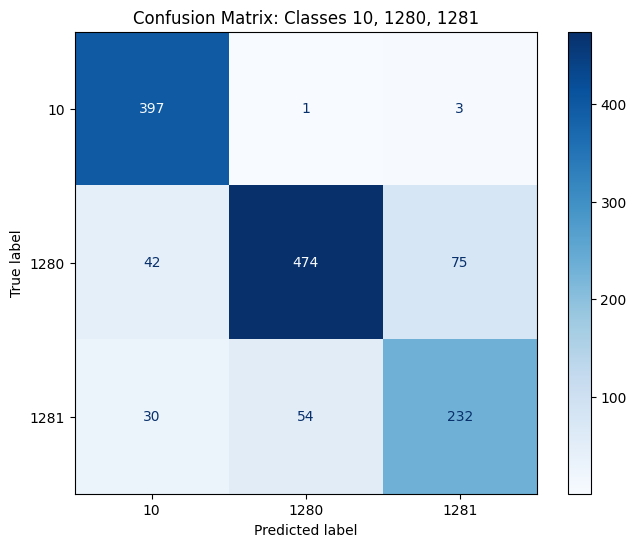


=== Détail des erreurs ===

Classe 10 (total=623):
  ✓ → 10: 397 (63.7%)
  ✗ → 2705: 99 (15.9%)
  ✗ → 2403: 46 (7.4%)
  ✗ → 2280: 26 (4.2%)
  ✗ → 1160: 19 (3.0%)

Classe 1280 (total=974):
  ✓ → 1280: 474 (48.7%)
  ✗ → 1300: 126 (12.9%)
  ✗ → 1281: 75 (7.7%)
  ✗ → 1140: 59 (6.1%)
  ✗ → 10: 42 (4.3%)

Classe 1281 (total=414):
  ✓ → 1281: 232 (56.0%)
  ✗ → 1280: 54 (13.0%)
  ✗ → 10: 30 (7.2%)
  ✗ → 1140: 17 (4.1%)
  ✗ → 2705: 14 (3.4%)



In [ ]:
target_classes = [10, 1280, 1281]

# Obtenir toutes les étiquettes de classes
all_classes = best_model.classes_

# Matrice de confusion complète
cm_full = confusion_matrix(y_valid, y_pred_best, labels=all_classes)

# Extraire les indices des classes cibles
target_idx = [np.where(all_classes == c)[0][0] for c in target_classes]

# Extraire la sous-matrice
cm_sub = cm_full[np.ix_(target_idx, target_idx)]

# Visualisation
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_sub, display_labels=target_classes)
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix: Classes 10, 1280, 1281")
plt.show()

# Voir vers quelles autres classes ces trois classes ont été mal classifiées
print("\n=== Détail des erreurs ===\n")
for c in target_classes:
    idx = np.where(all_classes == c)[0][0]
    row = cm_full[idx]
    print(f"Classe {c} (total={row.sum()}):")
    top_confusions = sorted(zip(all_classes, row), key=lambda x: -x[1])[:5]
    for pred_class, count in top_confusions:
        if count > 0:
            pct = count / row.sum() * 100
            label = "✓" if pred_class == c else "✗"
            print(f"  {label} → {pred_class}: {count} ({pct:.1f}%)")
    print()